<a href="https://colab.research.google.com/github/joaochenriques/MCTE_2020_2021/blob/main/LaRanceExample/LaRance_ebb_FSM_V02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as mpl
import numpy as np

In [2]:
%config InlineBackend.figure_formats = ['svg']
mpl.rcParams["figure.figsize"] = (12, 3)

## Turbine hill map and turbine operating curve
 
<img src="https://raw.githubusercontent.com/joaochenriques/MCTE_2020_2021/main/Barrages_Turbine_Generator_Maps/TurbineHill_Plot.svg" width="400px" style="display:inline">

In [3]:
class TurbineModel:

  def __init__( self, D_turb, Omega ):
    self.n11_min = 4.38
    self.n11_max = 17.17

    self.ga = 9.8 # gravity aceleration
    self.ρw = 1025.0 # water density
    self.CD_sluice = 1.0

    self.Omega = Omega
    self.D_turb = D_turb
    self.CT0 = Omega * D_turb / np.sqrt( self.ga )
    self.CT1 = D_turb**2 * np.sqrt( self.ga )
    self.A_turb = np.pi*(D_turb/2.0)**2

    # red line of the map
    self.poly_CQ1 = np.poly1d( np.array([0.16928201, 0.08989368]) )
    # green line of the map
    self.poly_CQ2 = np.poly1d( np.array([-3.63920467e-04,  9.37677378e-03, 
                                         -9.25873626e-02,  1.75687197e+00]) )

    # red line of the map
    self.poly_CE1 = np.poly1d( np.array([-0.02076456, 0.20238444, 0.48984553]) )
    # green line of the map
    self.poly_CE2 = np.poly1d( np.array([-2.75685709e-04,  2.04822984e-03,  
                                         6.86081825e-04,  7.93083108e-01]) )

  def n11_range( self ):
    return self.n11_min, self.n11_max

  def n11( self, h ):
    return self.CT0 / np.sqrt( np.max( (h, 0.0) ) )

  def Q11( self, n11 ):
    assert( n11 >= self.n11_min and n11 <= self.n11_max )
    if n11 < 7.92193025936073:
      return self.poly_CQ1( n11 ) 
    else:
      return self.poly_CQ2( n11 )

  def eta( self, n11 ):
    assert( n11 >= self.n11_min and n11 <= self.n11_max )
    if n11 < 7.92193025936073:
      return self.poly_CE1( n11 ) * 0.912
    else:
      return self.poly_CE2( n11 ) * 0.912

  def operation( self, h ):
    n11 = self.n11( h )
    QT = self.CT1 * self.Q11( n11 ) * np.sqrt( h )
    PH = self.ρw * self.ga * h * QT
    ηT = self.eta( n11 )
    return QT, PH, ηT  
  
  def sluicing( self, h ):
    QS = -self.CD_sluice * self.A_turb * np.sqrt( 2.0 * self.ga * np.max( (-h, 0.0) ) )
    return QS

## Generator efficiency curve

<img src="https://raw.githubusercontent.com/joaochenriques/MCTE_2020_2021/main/Barrages_Turbine_Generator_Maps/GeneratorEff_plot.svg" width="400px" style="display:inline">


In [4]:
class GeneratorModel:

  def __init__( self, Pgen_rated ):
    self.Pgen_rated = Pgen_rated

    self.poly_C1 = np.poly1d( np.array([-6.71448631e+03,  2.59159775e+03, 
                                        -3.80834059e+02,  2.70423225e+01, 
                                        3.29394948e-03]) )
    self.poly_C2 = np.poly1d( np.array([-1.16856952,  3.31172525, -3.44296217,  
                                        1.5416029 ,  0.71040716]) )
      
  def eta( self, shaft_power ):
    load = shaft_power / self.Pgen_rated
    assert( load >= 0 and load <= 1.0 )
    if load < 0.125423729:
      return self.poly_C1( load ) 
    else:
      return self.poly_C2( load )

In [5]:
class GateModel:

  def __init__( self, Area ):
    self.ga = 9.8
    self.Area = Area
    self.CD_sluice = 1.0

  def sluicing( self, h ):
    QS = -self.CD_sluice * self.Area * np.sqrt( 2.0 * self.ga * np.max( (-h, 0.0) ) )
    return QS

## Power plant operation finite state machine
 
<img src="https://raw.githubusercontent.com/joaochenriques/MCTE_2020_2021/main/LaRanceExample/EbbOperation.svg" width="700px" style="display:inline">

In [6]:
class BasinModel:

  def __init__( self, Area, h0 ):
    self.Area = Area
    self.V0 = Area * h0
    self.V = None

  def start( self ):
    self.V = self.V0
    return self.level()

  def integrate( self, delta_t, Q ):
    self.V = self.V - delta_t * Q
    return self.level()

  def level( self ):
      return self.V / self.Area

In [7]:
class TideModel:

  def __init__( self, ζ_tide, period ):
      self.ζ_tide = ζ_tide # tide amplitude
      self.period = period # tide period
      self.omega = 2.0 * np.pi / period 

  def level( self, t ):    
      return self.ζ_tide * np.cos( self.omega * t )

In [20]:
class EbbOperations_FSM:

    #===================================================
    def __init__( self ):
        self.transitions = { 0:self.__transition_0_1, 
                             1:self.__transition_1_2,
                             2:self.__transition_2_3,
                             3:self.__transition_3_4,
                             4:self.__transition_4_1 }

        self.states = { 0:self.__run_state_hold,
                        1:self.__run_state_generate,
                        2:self.__run_state_hold,
                        3:self.__run_state_fill,
                        4:self.__run_state_hold }         

        self.cur_state = 0

    #== TRANSITIONS ====================================
    def __transition_0_1( self, h, h_min, n11, n11_max ):
        if ( h - h_min ) > 0.0:
            self.cur_state = 1

    def __transition_1_2( self, h, h_min, n11, n11_max ):
        if ( n11 - n11_max ) >  0.0:
            self.cur_state = 2

    def __transition_2_3( self, h, h_min, n11, n11_max ):
        if h < 0.0:
            self.cur_state = 3

    def __transition_3_4( self, h, h_min, n11, n11_max ):
        if h > 0.0:
            self.cur_state = 4

    def __transition_4_1( self, h, h_min, n11, n11_max ):
        if ( h - h_min ) > 0.0:
            self.cur_state = 1

    #== STATES =========================================
    def __run_state_hold( self, h ):
        QS = QT = PH = ηT = ηG = 0
        return QS, QT, PH, ηT, ηG

    def __run_state_generate( self, h ):
        QS = 0.0
        QT, PH, ηT = turbine.operation( h )
        ηG = generator.eta( ηT * PH )
        return QS, QT, PH, ηT, ηG

    def __run_state_fill( self, h ):
        QS = gate.sluicing( h )
        QT = turbine.sluicing( h )
        PH = ηT = ηG = 0.0
        return QS, QT, PH, ηT, ηG

    #===================================================
    def transition( self, h, h_min, n11, n11_max ):
        self.transitions[ self.cur_state ]( h, h_min, n11, n11_max )
        return self.cur_state

    def run_state( self, h ):
        return self.states[ self.cur_state ]( h )

    #===================================================
    def run_model( self, delta_t, t_final, basin, turbines, generators, sluicing, h_min, n_turbs, n_gates ):

        #==============================================
        t = delta_t
        n = int( t_final / delta_t ) 

        #==============================================
        time_vec = np.zeros( n )
        tide_vec = np.zeros( n )

        s_vec  = np.zeros( n )  # control stages
        h_vec  = np.zeros( n )  # water height level
        z_vec  = np.zeros( n )  # basin level
        QS_vec = np.zeros( n )  # sluice gates + turbine flow rate on sluicing
        QT_vec = np.zeros( n )  # turbine flow rate
        PH_vec = np.zeros( n )  # hydraulic power
        ηT_vec = np.zeros( n )  # turbine efficiency
        ηG_vec = np.zeros( n )  # generator efficiency

        n11_min, n11_max = turbines.n11_range()
        z = basin.start()
        ζ = tide.level( 0.0 )
        h = z - ζ
        
        for i in range( 1, n ):

            t = i * delta_t

            n11 = turbines.n11( h )
            state = self.transition( h, h_min, n11, n11_max )
            QS, QT, PH, ηT, ηG = self.run_state( h )
 
            z = basin.integrate( delta_t, n_turbs*QT + n_gates*QS )
            ζ = tide.level( t )
            h = z - ζ

            time_vec[i] = t
            tide_vec[i] = ζ

            s_vec[i]  = state
            h_vec[i]  = h
            z_vec[i]  = z
            QS_vec[i] = QS
            QT_vec[i] = QT
            PH_vec[i] = PH
            ηT_vec[i] = ηT
            ηG_vec[i] = ηG
      
        return time_vec, tide_vec, s_vec, h_vec, z_vec, QS_vec, \
                QT_vec, PH_vec, ηT_vec, ηG_vec

In [27]:
n_turbs = 24 # number of turbines
n_gates = 6  # number of sluice gates
h_min = 8 # minimum h for turbine starting

tide_period = 12.0*3600.0 + 25.2*60.0

turbine = TurbineModel( D_turb = 5.35, Omega = 93.75*np.pi/30.0 )
generator = GeneratorModel( Pgen_rated = 60E6 )
gate = GateModel( Area = 10*15 )

tide = TideModel( ζ_tide = 6.75, period = tide_period )
basin = BasinModel( Area = 22E6, h0 = 5 )

simulator = EbbOperations_FSM()
time_vec, tide_vec, s_vec, h_vec, z_vec, QS_vec, QT_vec, PH_vec, ηT_vec, ηG_vec = \
    simulator.run_model( 100.0, 5*tide_period, basin, turbine, generator, gate, h_min, n_turbs, n_gates )

hours_vec = time_vec / 3600.0
period_hours = tide_period / 3600.0

PH_vec /= 1E6 # convert to MW
PT_vec = PH_vec * ηT_vec

PT_avg = np.mean( PT_vec )
PT_max = np.max( PT_vec )
C_fac = PT_avg / PT_max

print( "Plant Power = %.2f MW" % (PT_avg*n_turbs) ) 
print( "Plant Max P(t) = %.2f MW" % (PT_max*n_turbs) ) 
print( "Cap factor = %.2f" % C_fac )

Plant Power = 187.73 MW
Plant Max P(t) = 618.55 MW
Cap factor = 0.30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in double_scalars


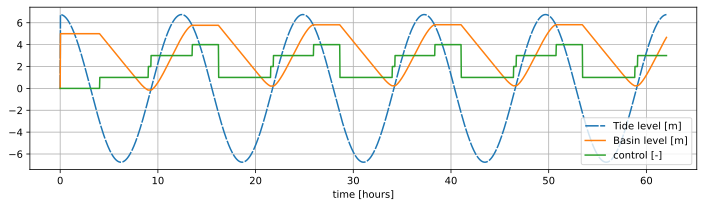

In [25]:
mpl.plot( hours_vec, tide_vec, label='Tide level [m]', dashes=(9,1) )
mpl.plot( hours_vec, z_vec, label='Basin level [m]' )
mpl.plot( hours_vec, s_vec, label='control [-]' )
#mpl.xlim( 3*period_hours, 5*period_hours )
#mpl.ylim( -6, 6 )
mpl.xlabel( 'time [hours]' )
mpl.legend()
mpl.grid();

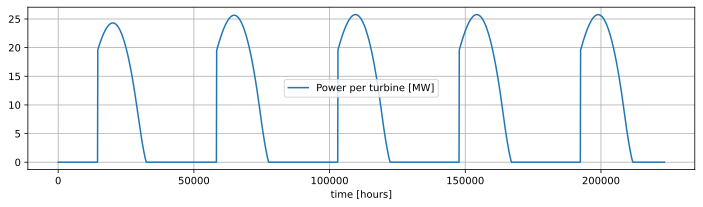

In [26]:
mpl.plot( time_vec, PT_vec, label='Power per turbine [MW]'  )
#mpl.xlim( 3*period_hours, 5*period_hours )
#mpl.ylim( 0, 30 )
mpl.xlabel( 'time [hours]' )
mpl.legend()
mpl.grid();

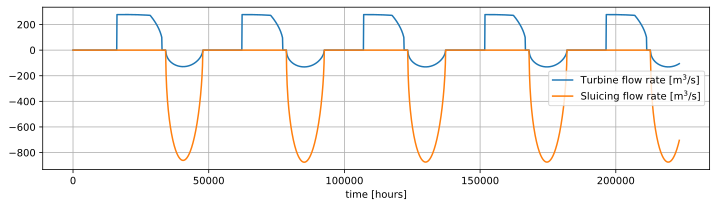

In [13]:
mpl.plot( time_vec, QT_vec, label='Turbine flow rate [m$^3$/s]' )
mpl.plot( time_vec, QS_vec, label='Sluicing flow rate [m$^3$/s]' )
#mpl.xlim( 3*period_hours, 5*period_hours )
mpl.xlabel( 'time [hours]' )
mpl.legend()
mpl.grid();

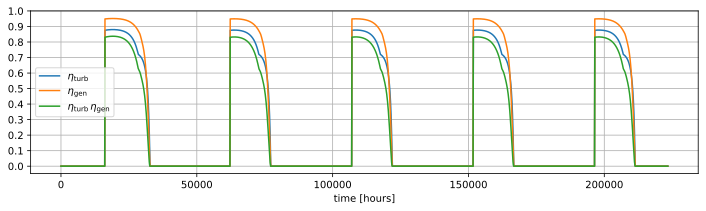

In [14]:
mpl.plot( time_vec, ηT_vec, label='$\eta_\mathrm{turb}$' )
mpl.plot( time_vec, ηG_vec, label='$\eta_\mathrm{gen}$' )
mpl.plot( time_vec, ηT_vec*ηG_vec, label='$\eta_\mathrm{turb}\,\eta_\mathrm{gen}$' )
#mpl.xlim( 3*period_hours, 5*period_hours )
mpl.xlabel( 'time [hours]' )
mpl.legend()
mpl.gca().set_yticks(np.arange( 0, 1.01, 0.1) )
mpl.grid();